# Rendering delle mappe

In [1]:
import pandas as pd
import folium
import math
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns
import numpy as np
import numpy
import pyproj
from scipy.stats import kde
import pathlib

## Importazione geolocalizzazioni

In [2]:
currentdir=pathlib.Path("../data/geolocalization/.")
currentpattern="*.csv"
counter=0
for currentfile in currentdir.glob(currentpattern):
  counter=counter+1
  print(currentfile)
  if (counter==1):
    df=pd.read_csv(currentfile, sep=";", encoding="iso8859_1")
  else:
    df=pd.concat([df, pd.read_csv(currentfile, sep=";", encoding="iso8859_1")])

..\data\geolocalization\0_to_1999_geoloc.csv
..\data\geolocalization\2000_to_3999_geoloc.csv
..\data\geolocalization\4000_to_5999_geoloc.csv


In [3]:
df

,Unnamed: 0,Unnamed: 0.1,anno,provincia,comune,giorno,organo_di_rilevazione,localizzazione_incidente,denominazione_della_strada,tronco_di_strada_o_autostrada,...,morti_entro_24_ore,morti_entro_30_giorni,feriti,descrizione_strada,Ora,chilometri,ettometrica,trimestre,Long,Lat
0,0,89310,16,15,146,6,2,1,,12,...,0,0,3,"Via della Chiesa Rossa, palo luce 160 ...",22,0,0,2,"9,1664403","45,4205456"
1,1,93706,16,15,146,5,1,1,000,12,...,0,0,1,STRADA URBANA ...,11,0,0,1,"9,189982","45,4642035"
2,2,93711,16,15,146,7,1,7,R20,,...,0,0,3,SVINCOLO A4 - MILANO VIALE CERTOSA ...,19,0,800,1,"9,1334786","45,5219824"
3,3,93715,16,15,146,3,1,7,R36,,...,0,0,1,A50 - SVINCOLO CON COLLEGAMENTO SS11-33 ...,9,0,700,1,"9,212911","45,45117390000001"
4,4,93725,16,15,146,4,1,5,046,12,...,0,0,1,STRADA PROVINCIALE 46 ...,9,4,400,1,"9,1474791","45,5486659"
5,5,93749,16,15,146,6,1,7,R20,,...,0,0,2,SVINCOLO A4 - MILANO VIALE CERTOSA ...,24,0,100,2,"9,1334786","45,5219824"
6,6,93768,16,15,146,3,1,7,R20,,...,0,0,2,SVINCOLO A4 - MILANO VIALE CERTOSA ...,20,0,500,2,"9,1334786","45,5219824"
7,7,93776,16,15,146,2,1,4,000,12,...,0,0,1,STRADA COMUNALE ...,20,0,1,2,"9,189982","45,4642035"
8,8,93781,16,15,146,1,1,7,A04,,...,0,0,1,SVINCOLO A4 - MILANO VIALE CERTOSA ...,12,126,300,2,"9,1334786","45,5219824"
9,9,93787,16,15,146,3,1,7,R20,,...,0,0,1,SVINCOLO A4 - MILANO VIALE CERTOSA ...,21,0,500,3,"9,1334786","45,5219824"


In [4]:
print("Numero di righe: ", len(df.index))

Numero di righe:  6000


In [5]:
# PER QUALCHE MOTIVO LONG E LAT SONO STRINGHE E HANNO LA VIRGOLA, CONVERTIAMOLE IN NUMERI DECENTI

In [6]:
df['Long']=df['Long'].apply(lambda x: float(str(x).replace(',', '.')))

In [7]:
df['Lat']=df['Lat'].apply(lambda x: float(str(x).replace(',', '.')))

In [8]:
# CENTRO DI MILANO, E VERIFICA TRASFORMAZIONE COORDINATE

In [9]:
duomo=[9.189982, 45.4642035]
pyproj.transform(pyproj.Proj(init="epsg:4326"), pyproj.Proj(init="epsg:3003"), duomo[0], duomo[1])

(1514880.0824769037, 5034557.197966876)

## RIMUOVIAMO IL DUOMO (probabilmente riferimenti non bel geolocalizzati)

In [10]:
b_duomo = (df.Long == duomo[0]) & (df.Lat == duomo[1])
df = df[~b_duomo]

## TRASFORMAZIONE DELLE COORDINATE

In [11]:
x=numpy.array([])
y=numpy.array([])
xgb=numpy.array([])
ygb=numpy.array([])
mymap=folium.Map([duomo[1], duomo[0]], zoom_start=11)

for counter in range(0, len(df.index)):
  mylocation=[float(df.iloc[counter, 119]), df.iloc[counter, 120]]
  if ((not math.isnan(mylocation[1])) & (not math.isnan(mylocation[0]))):
    deltax=0.15
    xmean=9.149733
    deltay=0.15
    ymean=45.449232
    if (mylocation[0]>xmean-deltax) & (mylocation[0]<xmean+deltax) & (mylocation[1]>ymean-deltay) & (mylocation[1]<ymean+deltay):
      x=numpy.append(x,[mylocation[0]])
      y=numpy.append(y,[mylocation[1]])
      x1, y1=mylocation[0], mylocation[1]
      x2, y2=pyproj.transform(pyproj.Proj(init="epsg:4326"), pyproj.Proj(init="epsg:3003"), x1, y1)
      xgb=numpy.append(xgb, x2)
      ygb=numpy.append(ygb, y2)
      if (counter<100): # SAMPLE DI 100 EVENTI O IL PLOT CRASHA
        folium.Marker([mylocation[1], mylocation[0]]).add_to(mymap)
print("Media long: ", numpy.mean(x), ", Devst long: ", numpy.std(x), " - Media lat: ", numpy.mean(y), ", Devst lat: ", numpy.std(y))
print("Lunghezza dati considerati: ", len(x))
print("Media long GB: ", numpy.mean(xgb), " - Media long GB: ", numpy.mean(ygb))

Media long:  9.181999812195533 , Devst long:  0.03691965516896579  - Media lat:  45.47278762110961 , Devst lat:  0.023541142445142275
Lunghezza dati considerati:  5912
Media long GB:  1514253.876355417  - Media long GB:  5035510.108472336


## Plot degli eventi

In [12]:
mymap

## Calcolo del numero di bin a partire dalla dimensione desiderata

In [13]:
hsize=max(xgb)-min(xgb)
vsize=max(ygb)-min(ygb)
print("Dimensione rettangolo considerato in metri:", hsize, vsize)
binsize_meters_desidered=50
nbins=np.round((hsize+vsize)/(2*binsize_meters_desidered))
print("Numero di bins lato x e y", nbins)
hsizebin=hsize/nbins
vsizebin=vsize/nbins
print("Dimensione bin: ", hsizebin, vsizebin)

Dimensione rettangolo considerato in metri: 17616.13769746595 18145.803690071218
Numero di bins lato x e y 358.0
Dimensione bin:  49.20708854040768 50.68660248623245


## RATE DENSITY PLOT

In [14]:
plt.rcParams["figure.figsize"] = (20,12)
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
#k = kde.gaussian_kde([x,y])
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
#kde.factor=1
#k = kde.gaussian_kde([xgb,ygb], bw_method="scalar")
k = kde.gaussian_kde([xgb,ygb])
xi, yi = np.mgrid[xgb.min():xgb.max():nbins*1j, ygb.min():ygb.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [15]:
print(sum(zi))
zi=zi/(sum(zi))*(len(x)/366)
print(sum(zi))

0.0003982269636800209
16.153005464480852


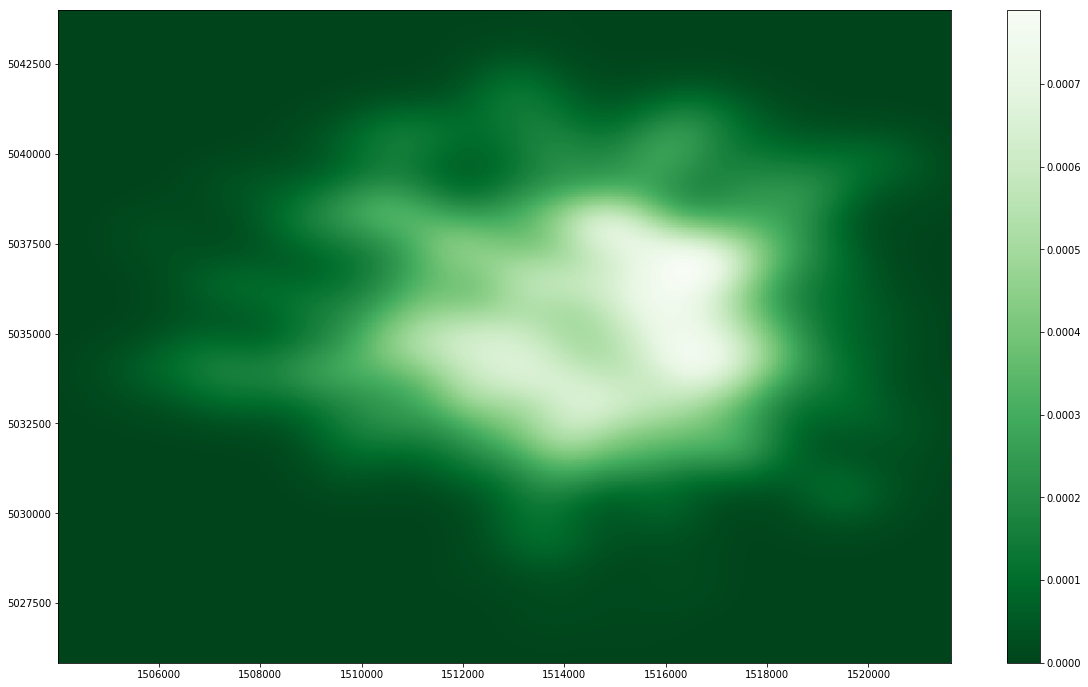

In [16]:
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
plt.colorbar()
plt.show()

In [17]:
np.mean(zi)*nbins*nbins

16.15300546448064

## HISTOGRAMMA 2D

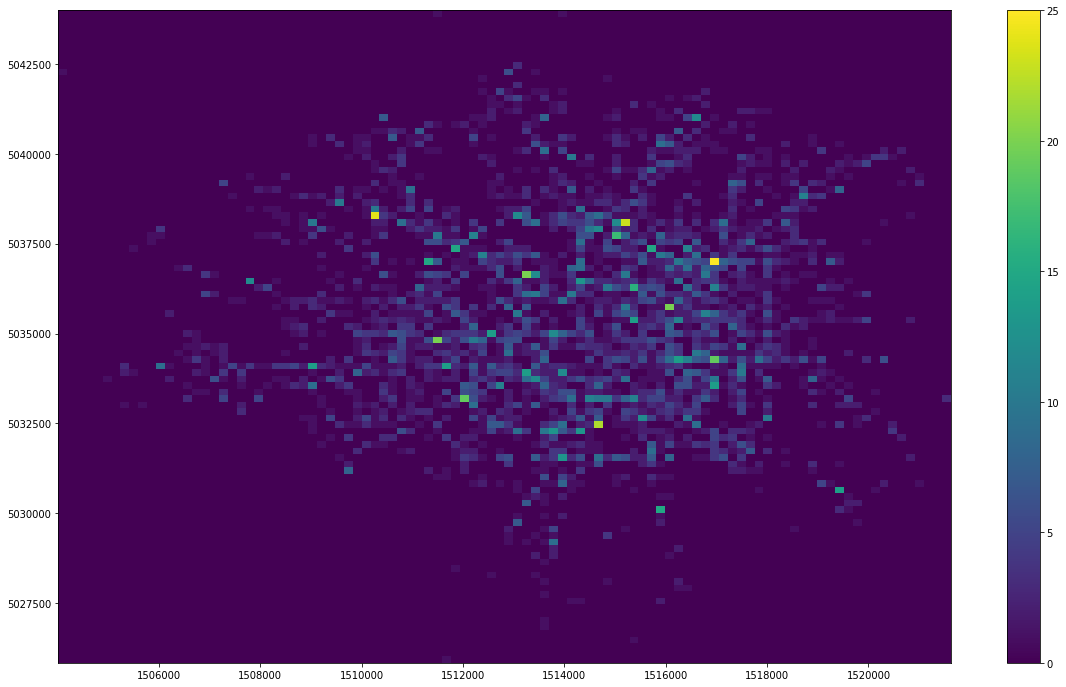

In [18]:
h=plt.hist2d(xgb, ygb, bins=100)
plt.colorbar()
plt.show()


## CERCHIAMO I BIN CON ALMENO 10 INCIDENTI

In [19]:
best=np.where(h[0]>=10)
print("Bin trovati   : ", len(best[0]))
print("Valore massimo: ", numpy.max(h[0]))

Bin trovati   :  71
Valore massimo:  25.0


In [20]:
xtop=np.array([])
ytop=np.array([])
ztop=np.array([])
for i in range(0, len(best[0])):
  xt,yt=pyproj.transform(pyproj.Proj(init="epsg:3003"), pyproj.Proj(init="epsg:4326"), h[1][best[0][i]], h[2][best[1][i]])
  zt=h[0][best[0][i]][best[1][i]]
  xtop=numpy.append(xtop, xt)
  ytop=numpy.append(ytop, yt)
  ztop=numpy.append(ztop, zt)
  print(xt, yt, zt)

9.098380948551096 45.480598600367074 12.0
9.114116169679571 45.459351030198256 14.0
9.114188508867183 45.49528364789701 10.0
9.120962704480075 45.50017658988076 10.0
9.129974298374089 45.4969001221684 24.0
9.129978046332655 45.49853341615527 10.0
9.143473178693862 45.48545090386287 15.0
9.14567696964168 45.46584846603204 20.0
9.145744171069989 45.491981238921014 10.0
9.147913325188737 45.45931236527593 14.0
9.150244392125241 45.48870882096186 15.0
9.15239765723814 45.451139931363585 19.0
9.154690574488352 45.46583664163181 10.0
9.154761943495945 45.49196940379073 11.0
9.157002801089405 45.487066450541974 11.0
9.159201962612578 45.46746376351608 14.0
9.16141821509486 45.45439418905554 11.0
9.165976707147456 45.47235405915634 10.0
9.166048521039384 45.49685348561722 12.0
9.168186736329405 45.457651064026955 14.0
9.168259471059446 45.48215055104749 20.0
9.170434898385455 45.456014428318795 12.0
9.170498770318028 45.477247326815544 10.0
9.17051352012128 45.4821472152046 12.0
9.172648115164

In [26]:
mymap=folium.Map([duomo[1], duomo[0]], zoom_start=12)
for counter in range(0, len(xtop)):
  mylocation=[ytop[counter], xtop[counter]]
  folium.CircleMarker(mylocation, radius=ztop[counter], fill=True).add_to(mymap)
mymap